In [1]:
from pprint import pprint
import pandas as pd
import numpy as np
import scipy as sp
import pickle
import cloudpickle
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from IPython.display import display
import shap
from comparers import ModelComparer, plot_decision_boundary
from util import RuleClassifier, get_complexity, find_counterfactuals, counterfactuals_to_constraint_matrix,\
                 evaluate
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order,\
                       plot_feature_importance_bar, plot_class_importances, print_rules
from clustering import make_clustering, eval_clusterings, plot_2d_with_boundaries, plot_dependence_curves_for_nodes
import warnings
shap.initjs()

In [2]:
with open('data/task.pickle', 'rb') as f:
    clf_a, clf_b, X, y, feature_names, feature_precisions = pickle.load(f)

In [3]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

In [4]:
# Do not sample from background data set but use all available instances
masker = shap.maskers.Independent(data=X, max_samples=X.shape[0])

In [5]:
from matplotlib.lines import Line2D
from matplotlib.collections import PathCollection
filter_lines = lambda handles, labels: zip(*filter(lambda t: not isinstance(t[0], Line2D), zip(handles, labels)))
filter_paths = lambda handles, labels: zip(*filter(lambda t: not isinstance(t[0], PathCollection), zip(handles, labels)))

# Generating Explanations

In [6]:
%%time
indiv_shap_values = generate_shap_explanations(comparer, X, masker=masker, explanation_type='indiv', space_type='labels')
with open('explanations/indiv.shap', 'wb') as f:
    pickle.dump(indiv_shap_values, f, pickle.HIGHEST_PROTOCOL)

CPU times: user 3.91 s, sys: 65.8 ms, total: 3.98 s
Wall time: 4.17 s


In [7]:
%%time
diffclf_shap_values = generate_shap_explanations(comparer, X, masker=masker, explanation_type='mclass_diff', space_type='labels')
with open('explanations/diffclf.shap', 'wb') as f:
    pickle.dump(diffclf_shap_values, f, pickle.HIGHEST_PROTOCOL)

CPU times: user 112 ms, sys: 5.64 ms, total: 118 ms
Wall time: 152 ms


In [8]:
%%time
for class_name in comparer.class_names:
    print(class_name)
    node = make_clustering(comparer, diffclf_shap_values, class_name,
                           feature_precisions=feature_precisions)
    with open(f'clustering.diffclf.{node.focus_class}.pickle', 'wb') as f:
        pickle.dump(node.state, f)

(0, 0)
(0, 1)
(1, 0)
(1, 1)
CPU times: user 15.8 s, sys: 90.8 ms, total: 15.8 s
Wall time: 16.1 s


In [6]:
with open('explanations/diffclf.shap', 'rb') as f:
    diffclf_shap_values = pickle.load(f)
with open('explanations/indiv.shap', 'rb') as f:
    indiv_shap_values = pickle.load(f)
with open(f'explanations/clustering.pickle', 'rb') as f:
    state = pickle.load(f)
node = make_clustering(comparer, indiv_shap_values, diffclf_shap_values, focus_class=None,
                       feature_precisions=feature_precisions, state=state)

# Interpretation

In [7]:
node = node.root
node.focus_class = None
classes = ['1']

I start by interpreting the individual classifiers' feature importances, shown in figure \ref{}. What's special about classifier B is, that $x_2$ has no importance at all. 

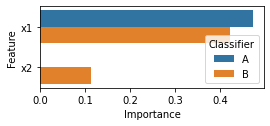

In [8]:
_, feature_importances_a = calc_feature_order(indiv_shap_values[:, :, 'A.1'])
_, feature_importances_b = calc_feature_order(indiv_shap_values[:, :, 'B.1'])
feature_order, _ = calc_feature_order(indiv_shap_values)
feature_idx = pd.Index(feature_names, name='Feature')
feature_importances_a = pd.Series(feature_importances_a.values, index=feature_idx, name='Importance')
feature_importances_b = pd.Series(feature_importances_b.values, index=feature_idx, name='Importance')
feature_importances = pd.concat({'A': feature_importances_a, 'B': feature_importances_b}, names=['Classifier'])
feature_importances = pd.DataFrame(feature_importances, columns=['Importance']).reset_index()
fig, ax = plt.subplots(figsize=(4, 1.5))
sns.barplot(orient='h', data=feature_importances, y='Feature', x='Importance', hue='Classifier', ax=ax)
plt.savefig('figures/running-shap-indiv-featimp.pdf', bbox_inches='tight', pad_inches=0)

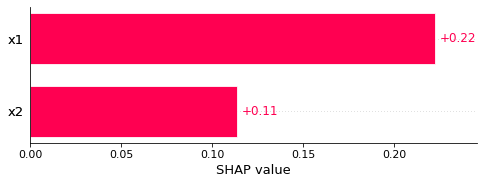

In [9]:
plot_feature_importance_bar(node.diff_feature_importances, feature_order=node.diff_feature_order)

In [10]:
from clustering import plot_indiv_dependence_curve_comparison_for_feature, _DEFAULT_FIGSIZE

This is confirmed in the individual dependence plots shown in figure \ref{fig:running-indiv-depplots}: $x_2$ has no effect on B's outcomes, because its dependence curve is constantly zero. According to the difference dependence plots in the right column, B overestimates class 1's outcome for low $x_1$ values and underestimates it for medium values. This already explains in part why one instance is classified $(0,1)$ and why eight instances are classified $(1,0)$. The first is above the zero line and the second is below it. For low $x_2$ values it overestimates the outcome, for medium values it underestimates the outcome and for high values it overestimates the outcome. This too explains the instances classified differently. I conclude, that B tends to predict label 1 more often than 0 for low $x_1$ values combined with high $x_2$ values. B further tends to predict label 0 more often than A for medium $x_1$ values and medium $x_2$ values.

In [11]:
from clustering import plot_dependence_curves_for_feature

This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


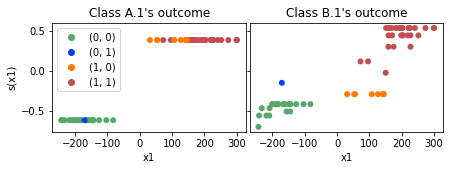

In [12]:
plot_dependence_curves_for_feature(node, 'x1', ['A.1', 'B.1'], kind='indiv', show_label_legend=False)
ax = plt.gca().figure.axes[0]
ax.legend()
plt.savefig('figures/running-indiv-depplots-x1-basic.pdf', bbox_inches='tight', pad_inches=0)

This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


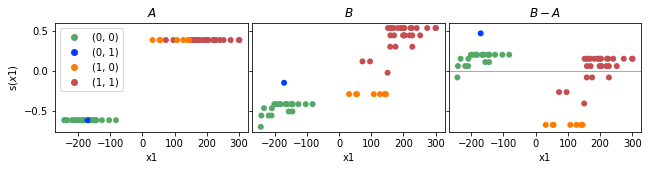

In [13]:
figsize = _DEFAULT_FIGSIZE
fig, axs = plt.subplots(ncols=3, figsize=(3*figsize[0], figsize[1]), squeeze=False, constrained_layout=True, sharex='all', sharey='all')
node.plot_indiv_feature_dependence('x1', classes=classes, axs=axs[0:1].T)
axs = plt.gca().figure.axes
axs[0].set_ylabel('s($x1$)')
axs[0].set_title('$A$')
axs[1].set_title('$B$')
axs[2].set_title('$B-A$')
axs[0].legend()
plt.savefig('figures/running-indiv-depplots-x1-final.pdf', bbox_inches='tight', pad_inches=0)

This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


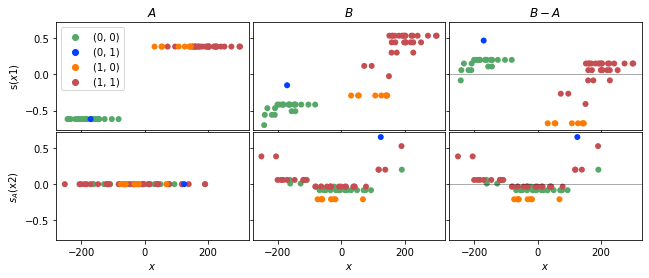

In [14]:
figsize = _DEFAULT_FIGSIZE
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(3*figsize[0], 2*figsize[1]), squeeze=False, constrained_layout=True, sharex='all', sharey='all')
node.plot_indiv_feature_dependence('x1', classes=classes, axs=axs[0:1].T)
node.plot_indiv_feature_dependence('x2', classes=classes, axs=axs[1:2].T)
axs = plt.gca().figure.axes
axs[0].set_ylabel('s($x1$)')
axs[0].set_title('$A$')
axs[1].set_title('$B$')
axs[2].set_title('$B-A$')
for ax in axs[3:]:
    ax.set_title(None)
    ax.set_xlabel('$x$')
axs[0].legend()
plt.savefig('figures/running-indiv-depplots.pdf', bbox_inches='tight', pad_inches=0)

In [15]:
node.indiv_shap_values[0].base_values

array([0.38333333, 0.61666667, 0.5       , 0.5       ])

To find concrete boundary values, I continue by interpreting difference classifier dependence plots.

## Focus on instances classified $(0,1)$

In [16]:
node = node.root
node.focus_class = '(0, 1)'
classes = ['(0, 0)', '(0, 1)', '(1, 1)']

This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


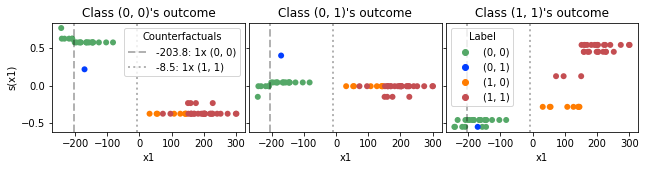

In [17]:
node.plot_feature_dependence('x1', classes=classes, show_legend=False)
axs = plt.gca().figure.axes
axs[2].get_legend().remove()
ax = axs[0]
ax.legend(*filter_paths(*ax.get_legend_handles_labels()), title='Counterfactuals', loc='upper right')
ax = axs[2]
ax.legend(*filter_lines(*ax.get_legend_handles_labels()), title='Label')
plt.savefig('figures/running-depplots-01-x1.pdf', bbox_inches='tight', pad_inches=0)

In [18]:
rule = node.rule_from_counterfactuals('x1')[0]
rule

'-203.8 < x1 <= -8.6'

In [19]:
alpha = node.filter(rule)
not_alpha = node.filter(f'not ({rule})')

This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


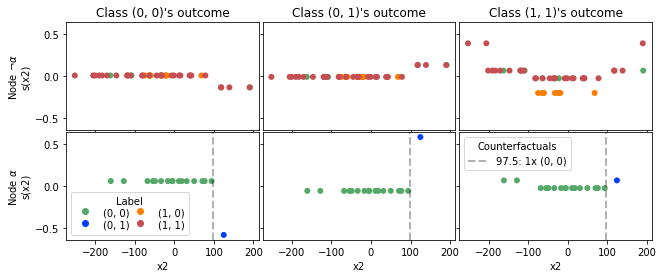

In [20]:
plot_dependence_curves_for_nodes(feature='x2', labels=classes, **{'$\\neg\\alpha$': not_alpha, '$\\alpha$': alpha}, show_legend=False)
ax = plt.gca().figure.axes[3]
ax.legend(*filter_lines(*ax.get_legend_handles_labels()), title='Label', loc='lower left', ncol=2, handleheight=1.5, columnspacing=0.02, labelspacing=0.02)
plt.savefig('figures/running-depplots-01-x2.pdf', bbox_inches='tight', pad_inches=0)

In [21]:
alpha.rule_from_counterfactuals('x2')[0]

'x2 > 97.5'

In [22]:
print(alpha.rule_from_counterfactuals(latex=True)[0])

-203.8 < x_1 \leq -8.6 \land x_2 > 97.5


I conclude, that B predicts 1 while A predicts 0 for instances having $-203.8 < x_1 \leq -8.6 \land x_2 > 97.5$.

## Focus on instances classified $(1, 0)$

In [84]:
node = node.root
node.focus_class = '(1, 0)'
classes = ['(0, 0)', '(1, 0)', '(1, 1)']

This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


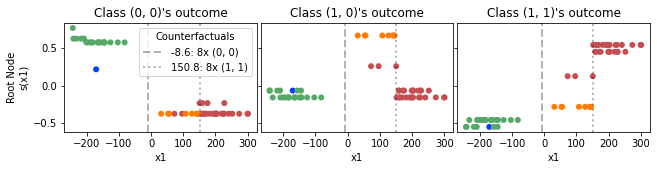

In [85]:
plot_dependence_curves_for_nodes(node, feature='x1', labels=classes, show_legend=False)
axs = plt.gca().figure.axes
axs[2].get_legend().remove()
ax = axs[0]
ax.legend(*filter_paths(*ax.get_legend_handles_labels()), title='Counterfactuals', loc='upper right')
plt.savefig('figures/running-depplots-10-x1.pdf', bbox_inches='tight', pad_inches=0)

In [86]:
rule = node.rule_from_counterfactuals('x1')[0]
rule

'-8.6 < x1 <= 150.7'

In [87]:
beta = node.filter(rule)
not_beta = node.filter(f'not ({rule})')

This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


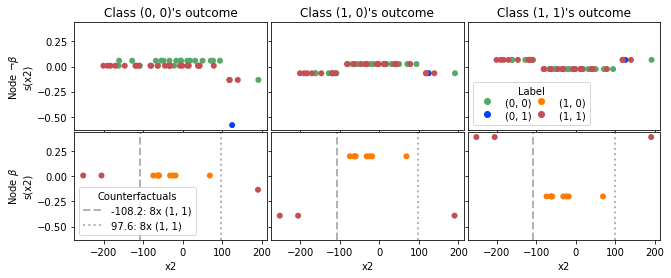

In [88]:
plot_dependence_curves_for_nodes(feature='x2', labels=classes, **{'$\\neg\\beta$': not_beta, '$\\beta$': beta}, show_legend=False)
ax = plt.gca().figure.axes[2]
ax.legend(*filter_lines(*ax.get_legend_handles_labels()), title='Label', ncol=2, handleheight=1.5, columnspacing=0.02, labelspacing=0.02)
axs = plt.gca().figure.axes
axs[5].get_legend().remove()
ax = axs[3]
ax.legend(*filter_paths(*ax.get_legend_handles_labels()), title='Counterfactuals', loc='lower left')
plt.savefig('figures/running-depplots-10-x2.pdf', bbox_inches='tight', pad_inches=0)

In [39]:
beta.rule_from_counterfactuals('x2')[0]

'-108.2 < x2 <= 97.5'

I conclude, that B predicts 0 while A predicts 1 for instances having $-8.6 < x_1 \leq 150.7 \land -108.2 < x_2 \leq 97.5$.

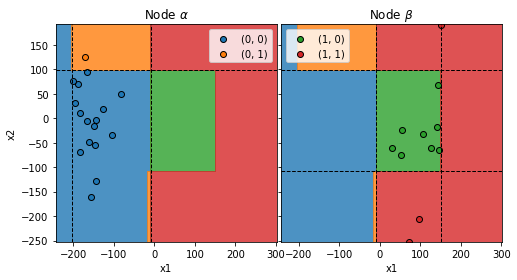

In [92]:
fig, axs = plt.subplots(ncols=2, figsize=(8, 4), sharex='all', sharey='all')
for idx, (name, n, ax) in enumerate(zip(['$\\alpha$', '$\\beta$'], [alpha, beta], axs)):
    is_first = idx == 0
    plot_2d_with_boundaries(n, fig=fig, ax=ax)
    if not is_first:
        ax.set_ylabel(None)
    ax.set_title(f'Node {name}')
plt.subplots_adjust(wspace=.02, hspace=.02)
plt.savefig('figures/running-instances.pdf', bbox_inches='tight', pad_inches=0)

# Evaluation

In [8]:
with open('explanations/diffclf.shap', 'rb') as f:
    diffclf_shap_values = pickle.load(f)

In [9]:
with open('data/test.pickle', 'rb') as f:
    X_test, y_test = pickle.load(f)

In [21]:
%%time
shap_values_test = generate_shap_explanations(comparer, X_test, masker=masker, explanation_type='mclass_diff', space_type='labels')
with open('explanations/test.shap', 'wb') as f:
    pickle.dump(shap_values_test, f)

Exact explainer: 10001it [00:18, 317.02it/s]                          


CPU times: user 17.7 s, sys: 428 ms, total: 18.1 s
Wall time: 19.1 s


In [10]:
with open('explanations/test.shap', 'rb') as f:
    shap_values_test = pickle.load(f)

In [12]:
metrics = eval_clusterings(node, X_test, shap_values_test)
metrics

,Precision,Recall,F1 Score,Support,Label,Nodes,Constraints,Distance
0,0.859601,0.999259,0.924184,4050.0,"(0, 0)",1,1,2.580556
1,0.981805,0.999259,0.990455,4050.0,"(0, 0)",2,2,0.043611
2,1.000000,0.999012,0.999506,4050.0,"(0, 0)",3,3,0.010000
3,1.000000,0.998765,0.999382,4050.0,"(0, 0)",5,7,0.000000
4,0.998397,0.942511,0.969650,661.0,"(0, 1)",1,3,2.580556
5,0.998774,0.999693,0.999233,3259.0,"(1, 0)",1,4,2.580556
6,0.383598,1.000000,0.554493,2030.0,"(1, 1)",1,1,2.580556
7,0.383598,1.000000,0.554493,2030.0,"(1, 1)",2,2,0.113889
8,0.383598,1.000000,0.554493,2030.0,"(1, 1)",3,3,0.033611
9,0.998524,0.999507,0.999015,2030.0,"(1, 1)",5,7,0.000000


<AxesSubplot:xlabel='Constraints', ylabel='F1 Score'>

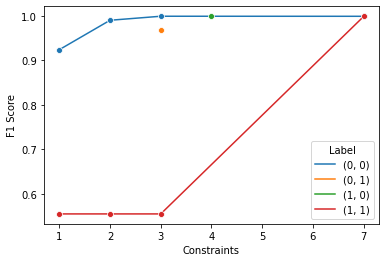

In [19]:
sns.lineplot(data=metrics, x='Constraints', y='F1 Score', hue='Label', marker='o')

In [14]:
with open('data/fidelity-shap.pickle', 'wb') as f:
    pickle.dump(metrics, f)